In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

### Survey Clean file, creating white/black lists

In [2]:
# Read it in
path = "surveys_clean.csv"
df = pd.read_csv(path, na_filter=False)

# Drop unnecessary columns
df.drop(columns=['ind_id', 'subject_id', 'image_name', 'image_name_2', 'index','outfits','outfits_comment'], inplace=True)

has_data = df['long']!=''
newDF = df[has_data]
newDF.shape

(5404, 2)

In [3]:
whiteDF = newDF[newDF['racial_group'] == 'white']['long']
blackDF = newDF[newDF['racial_group'] == 'black']['long']

whiteList = whiteDF.tolist()
blackList = blackDF.tolist()

In [4]:
whiteList[:5]

['i have no comments.',
 'to maney questions a like in the last here.  the rest alright overseas across',
 "why don't a soldiers have the right to take up any kind of work they want in the army.",
 'good thing if higher authorities get some action on this problems.',
 'some question overlap others and you might think i just checked them to get finished but i checked them as i feel.']

In [5]:
blackDF.head()

0    negro have been told many times they're fighti...
1    i dont like the army. i had rather be on the o...
2    i think that if were going to win this war, th...
3    why is it that the negro dont have the the rig...
4    i highly approve of this questionnaire it give...
Name: long, dtype: object

### DEIM-CUR functions

In [6]:
def cur(A, idx=False, SVD=None, rank=None):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M): # row/column selection
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = DEIM(np.transpose(Wt))
    C = A[:,p_C]
    
    p_R = DEIM(V)
    R = A[p_R]
    
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return (C,U,R, p_C, p_R) if idx else (C,U,R)

In [7]:
embed_white = (model.encode(whiteList))
embed_black = (model.encode(blackList))

### Top Responses for black respondents 

In [8]:
C_black,U_black,R_black, p_C_black, p_R_black = cur(np.transpose(embed_black), idx=True)

In [9]:
print("Black\n")
for i in range(20):
    print(blackList[p_C_black[i]])

Black

if the negro soldier is good enough to participate in the tough & rough army to help our country why not have privileges as same as the white man. since we are considered rotten & no good, we shouldn't't have to fight. we realize this is a white man's country but we are willing to fight for it because we live in it. therefore after this war i hope every negro will take this matter into consideration and force less segregation & a fair living as white people have. if all negro were like me things would be a hell of a lot better  site worse. we must show the white man we are all men together before we shall have equal rights. a man is a man no matter what race, creed or color, so why not be treated alike.
i think this questionnaire is good for us.
i don't like army in any way
i want to make more money to take care of my wife and get out the army so i can take care of her and my to kids
we don't get much to eat and we can't get attention our doctors when we are sick, the no  office

### Top Responses for white respondents 

In [10]:
 C_white,U_white,R_white, p_C_white, p_R_white = cur(np.transpose(embed_white), idx=True)

In [11]:
print("\nWhite\n")
for i in range(20):
    print(whiteList[p_C_white[i]])


White

in my opinion, the army life is alright. civilians treat us fairly good. i am contented because the boys in our outfit are just like brothers. we all complain as a whole. our officers and men are shifted so much we don't have chance to learn much. men are in our outfit who shouldn't't be here. they only hinder us. to many men kiss asses for their rating, while other, less conservative men who have ability, lose faith in the army and don't give a damn. as a result we have a lot of good men lost in the pile. we have a bunch of gold briggers and ass kissing non-coms, showing off their day old stripes. the officers conduct to many needless inspections, and are shifted around to much to be of any aid to the men under them. only men with brains should run the army. not ones with loud mouths.
i think this questionnaire is a good idea
no comments.
the army is a good place for every man if he is able to be in the army.
i would rather be home i could do more good on relief work.
why all 

## Eigenvalue Graphs (White)

In [12]:
white_first = pd.DataFrame({'Response': whiteList, 'Embedding': embed_white})
white_second = pd.DataFrame({'Response': whiteList})

In [13]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed_white)):
        x.append(white_first['Embedding'][j][i])
    white_second['x'+str(i)] = x
    
white_second.iloc[:,1:]

x0        x1        x2        x3        x4        x5        x6  \
0     0.758591  0.456631  1.158288 -0.455719 -0.180095  1.283310  0.706048   
1     0.454678 -0.536229  0.779319  0.193302 -0.092970 -0.065367 -0.889141   
2     0.422178  0.610620 -0.317593  0.041234  0.122884  0.505356  1.233452   
3    -0.170448 -0.680924  1.901574  0.523110 -0.252908 -0.436074  0.231396   
4     0.549441 -0.032283  0.780587  0.240238 -0.428685 -0.063074  0.501355   
5     0.004660 -0.301120  0.862109  0.273910 -0.373713 -0.793335  0.772640   
6     0.799952  0.370300  0.983754 -0.038101  0.426844 -1.270377  0.507401   
7    -0.467367  1.090383  0.241329  0.144277 -0.339844  0.133298  1.658487   
8     0.183044  0.378289 -0.555193  0.195641 -0.400503 -0.059412  0.462276   
9     0.025188  0.245247  0.461903  0.159790 -0.337907 -0.568613  1.127125   
10    0.334287  0.013280  0.619660  0.085012 -0.441737 -0.172548  1.046944   
11    0.054523 -0.259544 -1.510208  0.282933  0.038966  0.008620  1.294710   
12   -0.230980  0.118104  0.202880  0.447186 -0.503703 -0.362713  1.085288   
13    0.062695  0.497906 -0.055953 -0.069722 -0.357788 -1.039491  0.604923   
14   -0.440468  0.136333 -0.641939  0.584998 -0.283853 -0.416268  0.438233   
15    0.521716  1.102241 -0.563650  0.095452  0.420111  0.938649  1.074829   
16   -0.503587  0.881319 -0.207328  0.115960 -0.165285  0.143671  0.378964   
17    0.570290  0.393959 -0.047703  0.004079 -0.051032 -0.157831  0.601440   
18   -0.064357  0.401458 -0.359666  0.315233 -0.018028  0.247467  1.004153   
19   -0.407118  0.605017  0.150553  0.165064 -0.036967  0.702552  0.841669   
20    0.203790 -0.102026  0.878271  0.151073 -0.596000  0.017542 -0.447964   
21    0.488122 -0.413952  1.254836  0.080549  0.597010  0.186759  0.277266   
22    0.108239  0.461999  0.480178  0.227464  0.510953  0.115106  1.740188   
23    0.160673  0.660126  1.498898  0.300047 -0.494176 -0.783716  0.973390   
24   -0.306731  0.161289 -0.569952  0.428284  0.032119  0.231452  1.164013   
25   -0.384711 -0.772323 -0.258595  0.004123 -0.469370 -0.363515  0.384819   
26    0.353571  0.291967  0.079457 -0.074469 -0.100653 -0.145325  0.998835   
27    0.279563  0.280883 -0.604203  0.033437  0.123956 -0.264190  0.949306   
28    0.095421  0.097683  0.661615  0.130672 -0.494241 -0.129562  0.788030   
29    0.619392  0.948475 -0.612293 -0.058552 -0.179418  0.572516  1.864829   
...        ...       ...       ...       ...       ...       ...       ...   
1926 -0.257817  0.507086  0.044725  0.540854 -0.530896 -0.192224  0.497932   
1927  0.019220  0.152441 -0.124371  0.803387 -0.231130 -0.317207 -0.029504   
1928  0.007811  0.251395  0.150301  0.621764  0.055529  0.210444  0.449189   
1929 -0.185487 -0.075313  0.745931  0.384922 -0.299318 -0.751612  0.435846   
1930 -0.469826  0.303235  0.879333  0.456632 -1.022046 -0.216733  0.491382   
1931 -0.267626 -0.188729 -1.034687 -0.063323 -0.129148  0.747480  0.324590   
1932  0.084740  0.066332 -0.083777 -0.147853 -0.392003  0.383150  0.297698   
1933 -0.450974  0.211981 -0.009199  0.254582 -0.547022 -0.216932  0.649588   
1934  0.167383 -0.237567 -0.386790  0.457895 -0.461576 -0.020827  0.712137   
1935 -0.281709  0.168845  0.315795  0.501207 -0.233642 -0.806538  0.424059   
1936 -0.147670  0.227108  0.245045  0.853319  0.019616 -0.316324  0.755020   
1937  0.435913  0.012519  0.309652  0.460314  0.227806 -0.314343 -0.136995   
1938  0.382843  0.365518  0.808338  0.079468 -0.038667  0.540442  0.024523   
1939  0.118158 -0.392896  0.585570  0.232564 -0.097821 -0.444608  0.036477   
1940 -0.113912  0.160113  0.628255 -0.283375  0.173195 -0.585867  0.531699   
1941  0.003980  0.399760 -0.361218 -0.212603 -0.594133  0.352895  1.498449   
1942 -0.097858  0.379371  0.266798  0.517227 -0.392554 -0.243385  0.736234   
1943  0.772523 -0.921748 -0.170913  0.234455  0.350087  0.571567  1.696712   
1944  0.757774 -0.087299  1.518950 -0.113359  0.316028 -0.050781  0.808785   
1945  0.093673 -0.069371  0.345082

In [14]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=white_second.iloc[:,1:], nn=8)

In [15]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [16]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [17]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 1.4142135625218268
Max Norm: 44.22668877499196


In [18]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

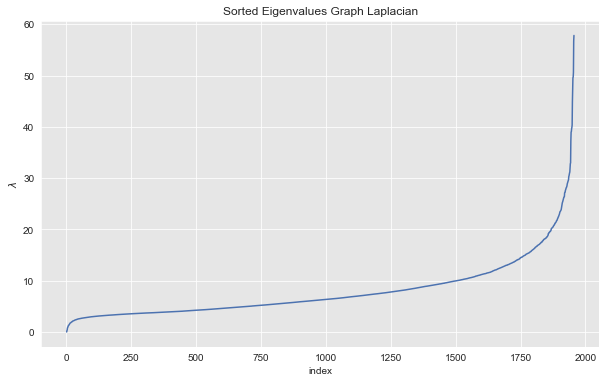

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

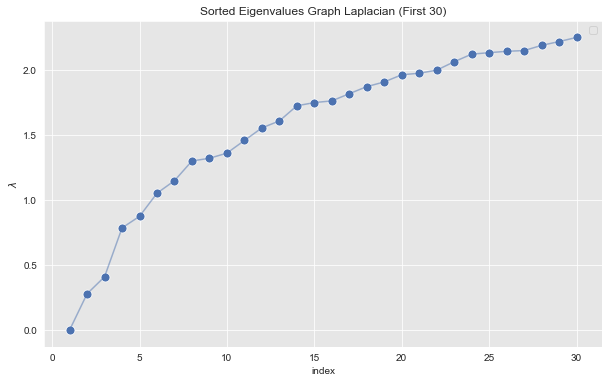

In [20]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

## Spectral Clustering on White respondents 

In [21]:
n=3

from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=n,affinity='nearest_neighbors').fit(white_second.iloc[:, 1:])
white_first['Cluster'] = [i for i in spectral.labels_]
white_first['bag'] = white_first.Response.map(lambda t:t.replace(';','').lower().split())

In [22]:
white_first.shape

(1956, 4)

In [23]:
whiteClusters = white_first
whiteClusters.drop(columns=['bag'], inplace=True)
whiteClusters.head()

Response  \
0                                i have no comments.   
1  to maney questions a like in the last here.  t...   
2  why don't a soldiers have the right to take up...   
3  good thing if higher authorities get some acti...   
4  some question overlap others and you might thi...   

                                           Embedding  Cluster  
0  [0.758591, 0.45663133, 1.1582876, -0.45571896,...        1  
1  [0.4546784, -0.5362293, 0.7793191, 0.19330154,...        0  
2  [0.42217788, 0.6106196, -0.317593, 0.04123385,...        0  
3  [-0.17044759, -0.6809244, 1.9015743, 0.5231100...        0  
4  [0.549441, -0.032282595, 0.780587, 0.24023785,...        0

### Method 3 Ranking Functions

In [24]:
def split_responses(responses):
    all_sentences = []
    response_numbers = []
    idx = 0
    for i in responses:
        temp = i.split('. ')
        for k in temp:
            response_numbers.append(idx)
        for j in temp:
            all_sentences.append(j)
        idx += 1
    return all_sentences, response_numbers


In [25]:
def get_index(rankings, responses):
    response_idx = []
    count = 0
    for i in rankings:
        temp = responses[i]
        if temp not in response_idx:
            response_idx.append(temp)
    return response_idx

In [26]:
def DEIM1(M): # row/column selection
        rank = np.linalg.matrix_rank(M)
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p

### Cluster 0 Top Responses

In [27]:
is_0 = white_first['Cluster'] == 0
cluster0 = white_first[is_0]

cluster0.head()


Response  \
1  to maney questions a like in the last here.  t...   
2  why don't a soldiers have the right to take up...   
3  good thing if higher authorities get some acti...   
4  some question overlap others and you might thi...   
5  when is the big drive is goning to start.  is ...   

                                           Embedding  Cluster  
1  [0.4546784, -0.5362293, 0.7793191, 0.19330154,...        0  
2  [0.42217788, 0.6106196, -0.317593, 0.04123385,...        0  
3  [-0.17044759, -0.6809244, 1.9015743, 0.5231100...        0  
4  [0.549441, -0.032282595, 0.780587, 0.24023785,...        0  
5  [0.004659554, -0.30111957, 0.8621086, 0.273910...        0

In [28]:
cluster0.shape

(1824, 3)

In [29]:
cluster_0 = [i for i in white_first['Response'][white_first['Cluster'] == 0]]

## Spectral Clustering on Cluster 0 (Too Ambigious)

In [30]:
cluster0List = cluster0['Response'].tolist()
embed0 = model.encode(cluster0List)

In [31]:
first0 = pd.DataFrame({'Response': cluster0List, 'Embedding': embed0})
second0 = pd.DataFrame({'Response': cluster0List})

In [32]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed0)):
        x.append(first0['Embedding'][j][i])
    second0['x'+str(i)] = x
    
second0.iloc[:,1:]

x0        x1        x2        x3        x4        x5        x6  \
0     0.454678 -0.536229  0.779319  0.193302 -0.092970 -0.065367 -0.889141   
1     0.422178  0.610620 -0.317593  0.041234  0.122884  0.505356  1.233452   
2    -0.170448 -0.680924  1.901574  0.523110 -0.252908 -0.436074  0.231396   
3     0.549441 -0.032283  0.780587  0.240238 -0.428685 -0.063074  0.501355   
4     0.004660 -0.301120  0.862109  0.273910 -0.373713 -0.793335  0.772640   
5     0.799952  0.370300  0.983754 -0.038101  0.426844 -1.270377  0.507401   
6    -0.467367  1.090383  0.241329  0.144277 -0.339844  0.133298  1.658487   
7     0.183044  0.378289 -0.555193  0.195641 -0.400503 -0.059412  0.462276   
8     0.025187  0.245247  0.461903  0.159790 -0.337908 -0.568614  1.127124   
9     0.334287  0.013279  0.619660  0.085012 -0.441737 -0.172547  1.046944   
10    0.054523 -0.259544 -1.510208  0.282933  0.038966  0.008620  1.294710   
11   -0.230981  0.118104  0.202879  0.447186 -0.503702 -0.362713  1.085287   
12    0.062695  0.497906 -0.055953 -0.069722 -0.357788 -1.039491  0.604922   
13   -0.440468  0.136333 -0.641939  0.584998 -0.283853 -0.416268  0.438233   
14    0.521716  1.102241 -0.563650  0.095452  0.420111  0.938649  1.074829   
15   -0.503587  0.881319 -0.207328  0.115960 -0.165285  0.143671  0.378964   
16    0.570290  0.393959 -0.047703  0.004079 -0.051032 -0.157831  0.601440   
17   -0.064357  0.401458 -0.359666  0.315233 -0.018028  0.247467  1.004153   
18   -0.407118  0.605017  0.150553  0.165064 -0.036967  0.702552  0.841669   
19    0.108239  0.461999  0.480178  0.227464  0.510953  0.115106  1.740188   
20    0.160673  0.660126  1.498898  0.300047 -0.494176 -0.783716  0.973390   
21   -0.306731  0.161289 -0.569952  0.428284  0.032119  0.231452  1.164013   
22   -0.384711 -0.772323 -0.258595  0.004123 -0.469370 -0.363515  0.384819   
23    0.353571  0.291967  0.079457 -0.074469 -0.100653 -0.145325  0.998835   
24    0.279563  0.280883 -0.604203  0.033437  0.123956 -0.264190  0.949306   
25    0.095421  0.097683  0.661615  0.130672 -0.494241 -0.129562  0.788030   
26    0.619392  0.948475 -0.612293 -0.058552 -0.179418  0.572516  1.864829   
27   -0.092426 -0.109134 -0.115197  0.201949 -0.097499  0.361400  0.560385   
28    0.185981  1.397219 -0.235487  0.178838 -0.678009 -0.067085  0.608824   
29   -0.099463  0.420035  0.392186  0.441001 -0.418383  0.095875  0.436131   
...        ...       ...       ...       ...       ...       ...       ...   
1794 -0.257817  0.507086  0.044725  0.540854 -0.530896 -0.192224  0.497932   
1795  0.019220  0.152441 -0.124371  0.803387 -0.231130 -0.317207 -0.029504   
1796  0.007811  0.251395  0.150301  0.621764  0.055529  0.210444  0.449189   
1797 -0.185487 -0.075313  0.745931  0.384922 -0.299318 -0.751612  0.435846   
1798 -0.469826  0.303235  0.879333  0.456632 -1.022046 -0.216733  0.491382   
1799 -0.267626 -0.188729 -1.034687 -0.063323 -0.129148  0.747480  0.324590   
1800  0.084740  0.066332 -0.083777 -0.147853 -0.392003  0.383150  0.297698   
1801 -0.450974  0.211981 -0.009199  0.254582 -0.547022 -0.216932  0.649588   
1802  0.167383 -0.237567 -0.386790  0.457895 -0.461576 -0.020827  0.712137   
1803 -0.281709  0.168845  0.315795  0.501207 -0.233642 -0.806538  0.424059   
1804 -0.147670  0.227108  0.245045  0.853319  0.019616 -0.316324  0.755020   
1805  0.435913  0.012519  0.309652  0.460314  0.227806 -0.314343 -0.136995   
1806  0.382843  0.365518  0.808338  0.079468 -0.038667  0.540442  0.024523   
1807  0.118158 -0.392896  0.585570  0.232564 -0.097821 -0.444608  0.036477   
1808 -0.113912  0.160113  0.628255 -0.283375  0.173195 -0.585867  0.531699   
1809  0.003980  0.399760 -0.361218 -0.212603 -0.594133  0.352895  1.498449   
1810 -0.097858  0.379371  0.266798  0.517227 -0.392554 -0.243385  0.736234   
1811  0.772523 -0.921748 -0.170913  0.234455  0.350087  0.571567  1.696712   
1812  0.757774 -0.087299  1.518950 -0.113359  0.316028 -0.050781  0.808785   
1813  0.093673 -0.069371  0.345082

In [33]:
graph_laplacian = generate_graph_laplacian(df=second0.iloc[:,1:], nn=8)

In [34]:
eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [35]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 1.4142135624413978
Max Norm: 42.708313008125245


In [36]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

/Users/yashsjoshi/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


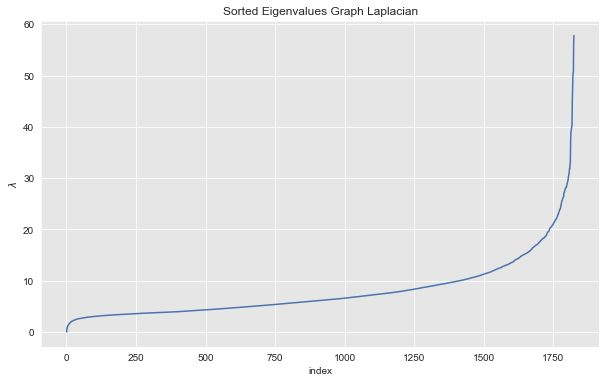

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

/Users/yashsjoshi/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/yashsjoshi/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


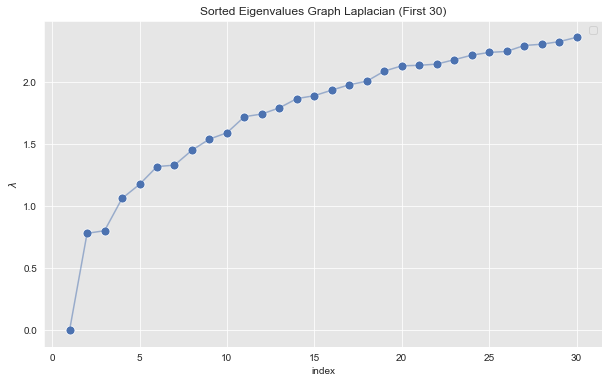

In [38]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [96]:
n=3

from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=n,affinity='nearest_neighbors').fit(second0.iloc[:, 1:])
first0['Cluster'] = [i for i in spectral.labels_]
first0['bag'] = first0.Response.map(lambda t:t.replace(';','').lower().split())

In [97]:
first0.head()

Response  \
0  to maney questions a like in the last here.  t...   
1  why don't a soldiers have the right to take up...   
2  good thing if higher authorities get some acti...   
3  some question overlap others and you might thi...   
4  when is the big drive is goning to start.  is ...   

                                           Embedding  Cluster  \
0  [0.4546784, -0.5362293, 0.7793191, 0.19330154,...        1   
1  [0.42217788, 0.6106196, -0.317593, 0.04123385,...        1   
2  [-0.17044759, -0.6809244, 1.9015743, 0.5231100...        0   
3  [0.549441, -0.032282595, 0.780587, 0.24023785,...        1   
4  [0.004659554, -0.30111957, 0.8621086, 0.273910...        1   

                                                 bag  
0  [to, maney, questions, a, like, in, the, last,...  
1  [why, don't, a, soldiers, have, the, right, to...  
2  [good, thing, if, higher, authorities, get, so...  
3  [some, question, overlap, others, and, you, mi...  
4  [when, is, the, big, drive, is, goning, to, st...

### Cluster 0-1 Top Responses

In [98]:
cluster_01 = [i for i in first0['Response'][first0['Cluster'] == 0]]

In [99]:
embed_split_01 = model.encode(split_responses(cluster_01)[0])

In [100]:
U01, S01, Vt01 = linalg.svd(embed_split_01, full_matrices = False)

In [101]:
ranking_01 = DEIM1(U01)
sentences_01, response_number_01 = split_responses(cluster_01)

In [124]:
[cluster_01[i] for i in get_index(ranking_01, response_number_01)][:20]

['i think this questionnaire is a very good idea because it gives a soldier the opportunity to express himself.',
 'i think this is a good thing to fill out. it lets you give your idea about how the army is run. how you are getting along. and have a few privileges.',
 'i think it is a good idea to get soldiers opinions on some things. some questions are worded so that limited service men are forced to answer questions that seem to give the wrong meaning.',
 'as long as you try to do your part you will get along o.k. in the army',
 "i think this is a hell of a good idea. democratic and a true picture of the feelings of people. lets have more questions. also lets be sure and make use of this information to better our country and its' army",
 'i think it is a very good idea about this questionnaire. it ought to help the people and soldiers during and after the war.',
 'this questionnaire is one of the best ideas the army has put out. you can state as you please and there will be no harm t

In [103]:
sentences_01[ranking_01[0]]

'i think this questionnaire is a very good idea because it gives a soldier the opportunity to express himself.'

In [104]:
sentences_01[ranking_01[1]]

'and have a few privileges.'

In [107]:
len(cluster_01)

170

### Cluster 0-2 Top Responses

In [105]:
cluster_02 = [i for i in first0['Response'][first0['Cluster'] == 1]]

In [106]:
embed_split_02 = model.encode(split_responses(cluster_02)[0])

In [108]:
U02, S02, Vt02 = linalg.svd(embed_split_02, full_matrices = False)

In [109]:
ranking_02 = DEIM1(U02)
sentences_02, response_number_02 = split_responses(cluster_02)

In [111]:
[cluster_02[i] for i in get_index(ranking_02, response_number_02)][:20]

["i have been in the air corps three months and so far it has been nothing but a game of politics. to make a rating, a fellow must do practically everything for his non-coms one of which is to keep him furnished with licqor and this is a little difficult to do when a guy doesn't drink himself.  soldiers are not too aware of the fact that we are fighting a war - our men should be more serious minded and i believe things would get along much better in the days to come.",
 'i think the person in charge of the physical education program here at atlantic city is out of his head. i was some what of an athlete before entering the army and considered my self in pretty good shape. instead of being physically outfit the men are being made physical wrecks. the most sleep i have ever gotten in one night is 7 hrs. and i go to bed as soon as i am permitted and as soon as i ready my equipment for the next day which is usually 9:pm 4:30 am we are up. this post is over run with colds & sore throats. th

In [112]:
sentences_02[ranking_02[0]]

' soldiers are not too aware of the fact that we are fighting a war - our men should be more serious minded and i believe things would get along much better in the days to come.'

In [113]:
sentences_02[ranking_02[1]]

'this is what i attribute it to.'

In [114]:
len(cluster_02)

1433

### Cluster 0_3 Top Responses

In [119]:
cluster_03 = [i for i in first0['Response'][first0['Cluster'] == 2]]

In [120]:
embed_split_03 = model.encode(split_responses(cluster_03)[0])

In [121]:
U03, S03, Vt03 = linalg.svd(embed_split_03, full_matrices = False)

In [122]:
ranking_03 = DEIM1(U03)
sentences_03, response_number_03 = split_responses(cluster_03)

In [123]:
[cluster_03[i] for i in get_index(ranking_03, response_number_03)][:20]

['a lot of the negro i think that we should treat them fair but not too give them to much power in what we are doing or going to do in the future.',
 'the segregation of black & white tends to break the unity  of our peoples. this unity is essential for complete victory.  i feel that the classification of soldiers is arbitrary. true, it is hard to classify millions of men & take individual differences into account. an effort may be made however for reclassification after basic training. company commanders should give men that chance.',
 '63 {circled continuation of question 63) non-coms would tend to reciprocate by bullying white privates + [and} therefore it would cause troubles. comments, why all the questions on racial differences in the u.s. ?',
 "about the negro and white there is goo and bad in every thing. i get along with some and some i don't of both color. i dont like the army, i tried to get in may. the non-comm's we have are from the south west and i dont like any of them o

In [126]:
sentences_03[ranking_03[0]]

'a lot of the negro i think that we should treat them fair but not too give them to much power in what we are doing or going to do in the future.'

In [127]:
sentences_03[ranking_03[1]]

'this unity is essential for complete victory'

In [128]:
len(cluster_03)

221

### Cluster 1 Top Responses

In [129]:
# is_1 = first['Cluster'] == 1
# cluster_1 = first[is_1]
# cluster1List = cluster_1['Response'].tolist()

cluster_1 = [i for i in white_first['Response'][white_first['Cluster'] == 1]]

In [130]:
# embed1 = np.transpose(model.encode(cluster1List))
embed_split_1 = model.encode(split_responses(cluster_1)[0])

In [131]:
# C_1,U_1,R_1, p_C_1, p_R_1 = cur(embed1, idx=True)
U1, S1, Vt1 = linalg.svd(embed_split_1, full_matrices = False)

In [132]:
# print("Cluster 1\n")
# for i in range(5):
#     if(i<len(p_C_1)):
#         print(i,':', whiteList[p_C_1[i]],'\n')

ranking_1 = DEIM1(U1)
sentences_1, response_number_1 = split_responses(cluster_1)

In [133]:
# cluster_1
[cluster_1[i] for i in get_index(ranking_1, response_number_1)][:20]

['none.',
 "sorry i haven't a present",
 '27 because i am small and not very bright',
 'no quistens to be asked',
 'this is nothing to do after retreat no place to go',
 "i don't have any thing to write.",
 'in regard to #27 i feel that i have not been given an opportunity to show my qualifications for a non-comm',
 'i have no comments.',
 'no question except i think this will never be looked at.',
 'i have none.',
 "i don't know any",
 "i haven't any proticualr things to say.",
 'none they answer themselves.',
 'no comment!!!',
 '(no statement)',
 'i have none to make.',
 'no comments made',
 "i don't have any.",
 'no comments.',
 'no comments.']

In [134]:
sentences_1[ranking_1[0]]

'none.'

In [135]:
sentences_1[ranking_1[1]]

"sorry i haven't a present"

### Cluster 2 Top Responses

In [136]:
# is_2 = first['Cluster'] == 2
# cluster_2 = first[is_2]
# cluster2List = cluster_2['Response'].tolist()

cluster_2 = [i for i in white_first['Response'][white_first['Cluster'] == 2]]

In [137]:
# embed2 = np.transpose(model.encode(cluster2List))
embed_split_2 = model.encode(split_responses(cluster_2)[0])

In [138]:
# C_2,U_2,R_2, p_C_2, p_R_2 = cur(embed2, idx=True)
U2, S2, Vt2 = linalg.svd(embed_split_2, full_matrices = False)

In [139]:
# print("Cluster 2\n")
# for i in range(5):
#     if(i<len(p_C_2)):
#         print(i,':', whiteList[p_C_2[i]],'\n')

ranking_2 = DEIM1(U2)
sentences_2, response_number_2 = split_responses(cluster_2)

In [140]:
[cluster_2[i] for i in get_index(ranking_2, response_number_2)][:20]

['i think the idea of this questionnaire is very good.',
 'its good',
 'i think i have made all my comments.',
 'no comment from me, a fairly right questionnaire.',
 'this questionnaire is all right. it gives us enlisted men a chance to express our minds.',
 'what  does this help',
 'it was a very interesting set of questions, calling for a little more thinking on my part than i ordinarily do.',
 'it is a very good idea so they know just how the boys feel',
 'i believe this is a very good way of finding out the opinion of all soldiers of what is going on.',
 'this is a good idea to let spec up our own opinion',
 'i think it be enough, and i think we doing for our country i be welcome to do my duties',
 'the questions where fair.',
 'every thing is going just fine with me',
 'i think it is a good thing if the right ones read it',
 'i believe it has been a very good idea, the questionnaire etc. thanks for the opportunity for a frank expression of my opinions.',
 'it is a very good questi

In [141]:
sentences_2[ranking_2[0]]

'i think the idea of this questionnaire is very good.'

In [142]:
sentences_2[ranking_2[1]]

'its good'

## Confusion Matrix

In [143]:
def confusion(X, Y,A,B):
    #Get desire Shapes
    W = np.transpose(X)
    V = np.transpose(Y)
    
    
    norm_W = np.zeros(np.shape(W))
    norm_V = np.zeros(np.shape(V))
    
    for i in range(0, np.shape(norm_W)[1]):
        temp = W[:, i] / np.linalg.norm(W, axis = 0)[i]
        norm_W[:, i] = temp
    for i in range(0, np.shape(norm_V)[1]):
        temp = V[:, i] / np.linalg.norm(V, axis = 0)[i]
        norm_V[:, i] = temp
    
    WtV = np.transpose(norm_W) @ norm_V
    
    for i in range(len(WtV)):
        for x in range(len(WtV[i])):
            WtV[i][x] = abs(WtV[i][x])
            if(WtV[i][x] <= 0.1):
                if(i not in A):
                    A.append(i)
                if(x not in B):
                    B.append(x)
    
    return WtV

## White responses embeddings for confusion matrices

In [145]:
white_embed_01 = model.encode(cluster_01)
white_embed_02 = model.encode(cluster_02)
white_embed_03 = model.encode(cluster_03)
white_embed_1 = model.encode(cluster_1)
white_embed_2 = model.encode(cluster_2)

Embed 02 vs Embed 03 <br>
-both clusters were split from ambigious 'Cluster 0' <br>
-Embed 02 is about military, soldiers, physical exerice <br>
-Embed 03 covers race

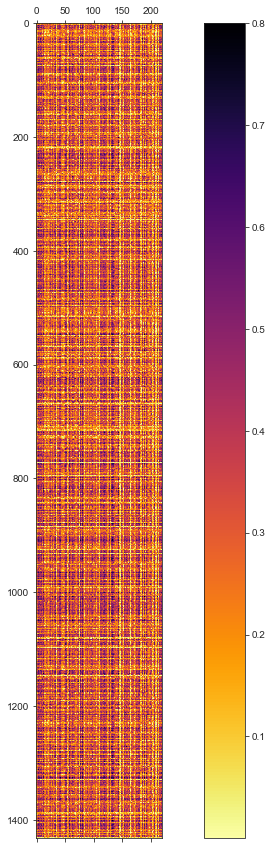

In [146]:
sns.set_style("ticks")
X_01 = []
Y_01 = []
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(white_embed_02, white_embed_03,X_01,Y_01), cmap='inferno_r')
img.figure.colorbar(img)

In [147]:
X_01

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,

Embed 01 and Embed 2 have the same responses

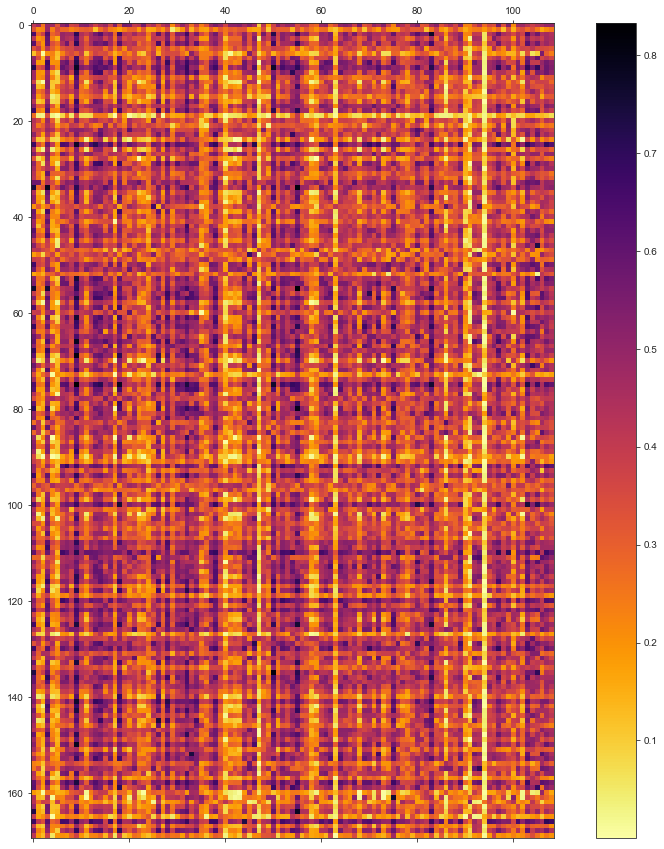

In [148]:
sns.set_style("ticks")
X_02 = []
Y_02 = []
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(white_embed_01, white_embed_2,X_02,Y_02), cmap='inferno_r')
img.figure.colorbar(img)

In [149]:
X_02

[0,
 1,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 129,
 130,
 131,
 132,
 133,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 167,
 168,
 169]

Embed 1 vs Embed 1

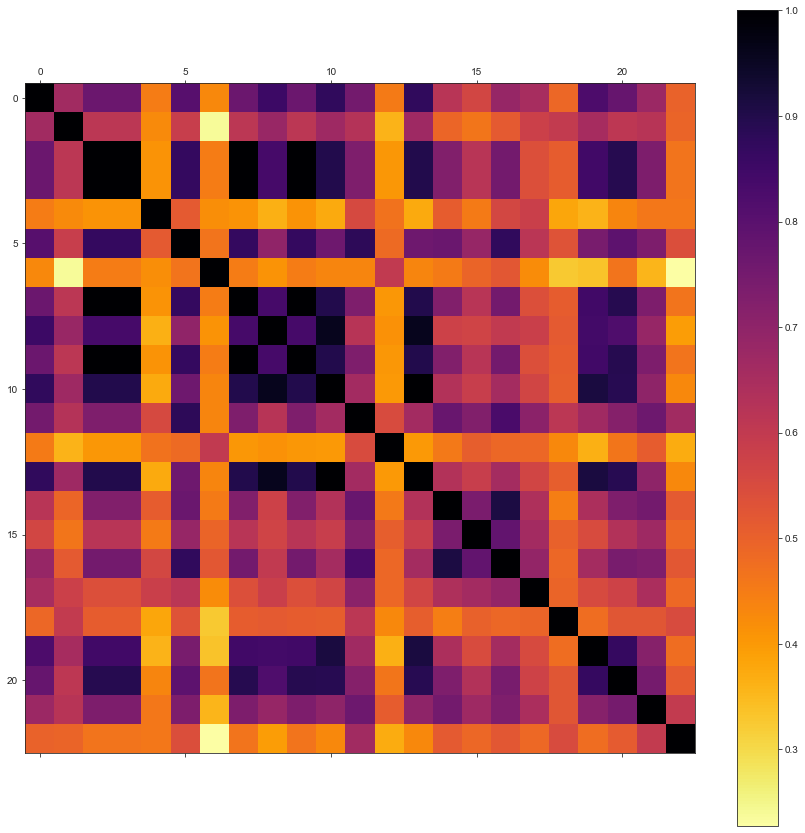

In [150]:
sns.set_style("ticks")
X_1 = []
Y_1 = []
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(white_embed_1, white_embed_1,X_1,Y_1), cmap='inferno_r')
img.figure.colorbar(img)

In [151]:
Y_1

[]

Embed 2 vs Embed 2

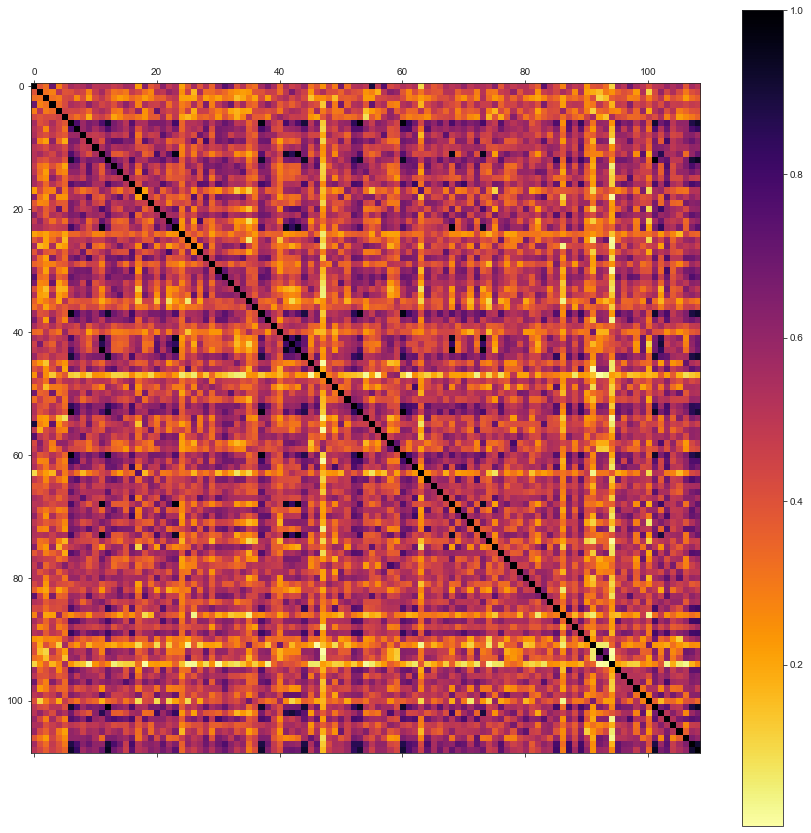

In [152]:
sns.set_style("ticks")
X_2 = []
Y_2 = []
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(white_embed_2, white_embed_2,X_2,Y_2), cmap='inferno_r')
img.figure.colorbar(img)

In [153]:
X_2

[0,
 5,
 9,
 13,
 14,
 17,
 18,
 20,
 22,
 24,
 25,
 26,
 28,
 30,
 32,
 33,
 34,
 35,
 38,
 42,
 45,
 46,
 47,
 49,
 54,
 55,
 56,
 61,
 62,
 63,
 70,
 71,
 72,
 74,
 75,
 76,
 82,
 83,
 86,
 88,
 91,
 92,
 93,
 94,
 100,
 103,
 105,
 106]

## Eigenvalue Graph (Black)

In [154]:
black_first = pd.DataFrame({'Response': blackList, 'Embedding': embed_black})
black_second = pd.DataFrame({'Response': blackList})

In [155]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed_black)):
        x.append(black_first['Embedding'][j][i])
    black_second['x'+str(i)] = x
    
black_second.iloc[:,1:]

x0        x1        x2        x3        x4        x5        x6  \
0    -0.431953 -0.633117 -0.260997  0.415460 -0.237683  0.366318  0.100023   
1    -0.214992  0.580386  0.443751  0.505816 -0.749663 -0.185046  0.921740   
2    -0.221185 -0.399868 -0.199939  0.446165 -0.415950  0.128538  0.631262   
3    -0.295477  0.572017 -0.411632  0.144846 -0.018772 -0.431764  0.487732   
4    -0.574096  0.517165  0.017152  0.162733 -0.337314 -0.444252  0.936755   
5    -0.129600 -0.261325  0.835405  0.506072  0.061220 -0.294037  0.120656   
6     0.705506  0.260656  1.377129 -0.589358 -0.328145 -0.258725 -0.291662   
7    -0.100324  0.106731 -0.172789 -0.011465  0.139848 -0.310977  0.551033   
8    -0.162554  0.039374  0.028283  0.265046  0.288264  0.369567  0.081332   
9     0.535083  0.356359  1.297027 -0.067209  0.407620 -0.337240  0.114972   
10    0.026506  0.283260  0.978467 -0.014222 -0.527761  0.093358  0.749793   
11   -0.356971 -0.293730  1.491101  0.387533  0.212057  0.147502  0.778248   
12    0.000684 -0.466135  1.552393  0.492578 -0.206176 -0.260971  0.123901   
13   -0.236952  0.138661  0.500620  0.271921  0.144456 -0.518912  0.456670   
14   -0.423566  0.228204 -0.163006  0.042594 -0.221372  0.109106  0.019312   
15   -0.563119 -0.257006  0.599946  0.210833 -0.958288  0.769769  0.381577   
16    0.396662  0.419927 -0.204954 -0.029617  0.116329  0.095091  1.075261   
17    0.286900  0.345179 -0.286462  0.316812 -0.126887 -0.465588  0.803479   
18   -0.016436  0.711111  0.685763  0.402312 -0.090327  0.529569 -0.050505   
19    0.548617  0.446395  0.840933  0.216336 -0.032789 -0.175040  0.060607   
20    0.165966 -0.010748 -0.048659  0.083690  0.475248  0.787552  1.026453   
21    0.200626 -0.277974  0.155482 -0.108129 -0.684944  0.768662  0.697675   
22   -0.278524  0.085282  0.393605  0.086840 -0.547611  0.032676  0.530198   
23   -0.871238  0.163428 -0.252853 -0.255073  0.247626 -0.036757  0.115390   
24   -0.202100  0.446551  0.041000  0.032441 -0.868442 -0.607697 -0.017420   
25   -0.206280  0.292624  1.249910  0.387520 -0.296932 -0.505377  0.584614   
26   -0.130497  0.511177  0.645813  0.077053 -0.165030  0.358409  0.818156   
27    0.037442 -0.128667  0.697776  0.592314 -0.222879 -0.499276  0.270144   
28   -0.362312  0.685140 -0.790672  0.476186 -0.292352 -0.985503  0.203140   
29   -0.185246 -0.330225  0.197835  0.159827 -0.283082  0.208064 -0.190752   
...        ...       ...       ...       ...       ...       ...       ...   
3418 -0.586604  0.186888  0.210849  0.147153 -0.446920  0.106907  0.288227   
3419  0.110176  0.619969 -0.228552  0.105129  0.257782  0.045987  1.363568   
3420 -0.349292  0.028604  0.038643 -0.003943 -0.257598 -0.418480  0.984310   
3421 -0.776319 -0.083648 -1.166538  0.270524 -0.277137  0.135127  0.468949   
3422 -0.064269 -0.173351 -0.575342  0.473421 -0.236818  0.241592 -0.083574   
3423 -0.686871 -0.378488  0.507278  0.600266  0.059845  0.663516 -0.017605   
3424 -0.136057  0.120152  0.038133  0.089821 -0.244021 -0.323933  1.201858   
3425 -0.416805  0.326846 -0.218065  0.508628 -0.271859 -0.632134  0.411156   
3426 -0.019285  0.473083 -0.497350  0.098253  0.027500 -0.317992  0.435380   
3427 -0.050171 -0.025388  0.231659  0.134976  0.204178  0.220246  1.213874   
3428  0.118536 -0.087489 -1.220506  0.085177  0.027541  0.308322  0.355685   
3429 -0.162716  0.279452  0.168025  0.295318 -0.054016 -0.038404  0.707461   
3430 -0.271128  0.378220 -0.887811  0.207151  0.584292 -0.288495  0.468128   
3431 -0.087573  0.482706 -0.603961  0.049256  0.280875  0.212273  0.294603   
3432  0.029791 -0.405090  2.001114  0.576822 -0.051270  0.334063 -0.500357   
3433  0.003204  0.539834 -0.873888  0.358689  0.035606 -0.274694  0.911870   
3434  0.283375 -0.240400 -0.319103  0.766777 -0.325694  0.256720  0.263273   
3435  0.272061  0.390454 -0.227873  0.281051 -0.351792  0.029071  1.928004   
3436  0.225823  0.218776 -1.207139  0.062307 -0.188951  0.244743  0.262214   
3437  0.360734  0.346713  0.106541

In [156]:
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

    
graph_laplacian = generate_graph_laplacian(df=black_second.iloc[:,1:], nn=8)

In [157]:
eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [158]:
eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [159]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 2.5463820878214065
Max Norm: 58.7196730236128


In [160]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

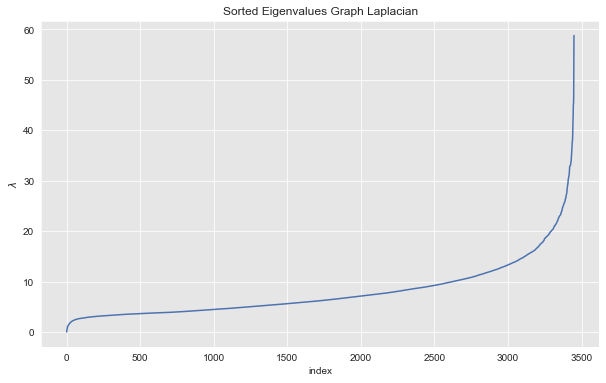

In [161]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

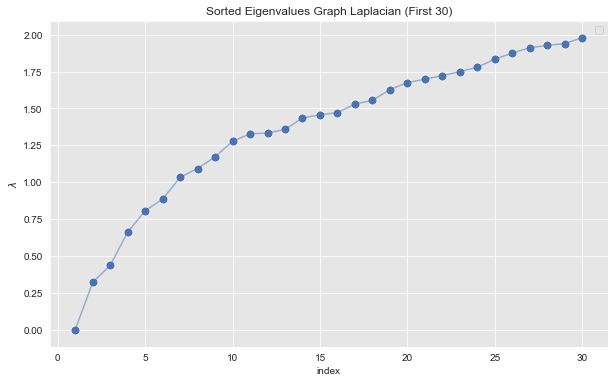

In [162]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

### Spectral Clustering on Black Respondents

In [163]:
n=6
spectral = SpectralClustering(n_clusters=n,affinity='nearest_neighbors').fit(black_second.iloc[:, 1:])
black_first['Cluster'] = [i for i in spectral.labels_]
black_first['bag'] = black_first.Response.map(lambda t:t.replace(';','').lower().split())

In [164]:
black_first.head()

Response  \
0  negro have been told many times they're fighti...   
1  i dont like the army. i had rather be on the o...   
2  i think that if were going to win this war, th...   
3  why is it that the negro dont have the the rig...   
4  i highly approve of this questionnaire it give...   

                                           Embedding  Cluster  \
0  [-0.43195295, -0.6331174, -0.26099682, 0.41546...        4   
1  [-0.21499196, 0.58038604, 0.44375092, 0.505815...        4   
2  [-0.22118457, -0.39986774, -0.19993901, 0.4461...        4   
3  [-0.29547727, 0.57201684, -0.41163206, 0.14484...        4   
4  [-0.57409626, 0.5171654, 0.01715225, 0.1627326...        4   

                                                 bag  
0  [negro, have, been, told, many, times, they're...  
1  [i, dont, like, the, army., i, had, rather, be...  
2  [i, think, that, if, were, going, to, win, thi...  
3  [why, is, it, that, the, negro, dont, have, th...  
4  [i, highly, approve, of, this, questionnaire, ...

In [165]:
blackClusters = black_first
blackClusters.drop(columns=['bag'], inplace=True)
blackClusters.head()

Response  \
0  negro have been told many times they're fighti...   
1  i dont like the army. i had rather be on the o...   
2  i think that if were going to win this war, th...   
3  why is it that the negro dont have the the rig...   
4  i highly approve of this questionnaire it give...   

                                           Embedding  Cluster  
0  [-0.43195295, -0.6331174, -0.26099682, 0.41546...        4  
1  [-0.21499196, 0.58038604, 0.44375092, 0.505815...        4  
2  [-0.22118457, -0.39986774, -0.19993901, 0.4461...        4  
3  [-0.29547727, 0.57201684, -0.41163206, 0.14484...        4  
4  [-0.57409626, 0.5171654, 0.01715225, 0.1627326...        4

### Cluster 0 Top Responses (Black)

In [166]:
# is_0 = first['Cluster'] == 0
# cluster_0 = first[is_0]
# cluster0List = cluster_0['Response'].tolist()

In [167]:
# cluster_0.shape

In [168]:
# embed0 = np.transpose(model.encode(cluster0List))

In [169]:
# C_0,U_0,R_0, p_C_0, p_R_0 = cur(embed0, idx=True)

In [170]:
# print("Cluster 0\n")
# for i in range(5):
#     if(i<len(p_C_0)):
#         print(i,':', blackList[p_C_0[i]],'\n')

In [171]:
cluster_0 = [i for i in black_first['Response'][black_first['Cluster'] == 0]]

In [172]:
len(cluster_0)

989

In [173]:
embed_split_0 = model.encode(split_responses(cluster_0)[0])
U0, S0, Vt0 = linalg.svd(embed_split_0, full_matrices = False)
ranking_0 = DEIM1(U0)
sentences_0, response_number_0 = split_responses(cluster_0)
[cluster_0[i] for i in get_index(ranking_0, response_number_0)][:20]

['i like the camp where i am at but i dont like infantry. i would like to be in quarter-master. i would seccused much better that is my idea.',
 "i will be glad when the war is over i have been in the army nine months an  had a furlough. i'll be happy to get on. i wish they would change the cooks in co. c. 827.",
 "the camps are really filled with men that could do more for the country by working in defense plants than they can as a soldier. i will be forty 41 yrs old next month and feel  three months in the army than i have a year ago. after i get through drilling i am through tired and sore to the bone. all recreation and service clubs in the south should be separate. thanks to new york camp upton you can go any way eat any way no trouble but down here that's not. i would really like to be out of this berg before i go nuts. this place is no good. camp shelly miss",
 'no 31 have not never been train never have shot a gun sense i been in the army  8 under decide  no 21  i could make go

In [174]:
sentences_0[ranking_0[0]]

'i like the camp where i am at but i dont like infantry'

In [175]:
sentences_0[ranking_0[1]]

"i'll be happy to get on"

### Cluster 1 Top Responses (Black)

In [176]:
# is_1 = first['Cluster'] == 1
# cluster_1 = first[is_1]
# cluster1List = cluster_1['Response'].tolist()

In [177]:
# embed1 = np.transpose(model.encode(cluster1List))

# C_1,U_1,R_1, p_C_1, p_R_1 = cur(embed1, idx=True)

# print("Cluster 1\n")
# for i in range(5):
#     if(i<len(p_C_1)):
#         print(i,':', blackList[p_C_1[i]],'\n')

In [178]:
cluster_1 = [i for i in black_first['Response'][black_first['Cluster'] == 1]]

In [179]:
len(cluster_1)

203

In [180]:
embed_split_1 = model.encode(split_responses(cluster_1)[0])
U1, S1, Vt1 = linalg.svd(embed_split_1, full_matrices = False)
ranking_1 = DEIM1(U1)
sentences_1, response_number_1 = split_responses(cluster_1)

In [181]:
sentences_1[ranking_1[0]]

'-- the bus service  to and from our post is extremely poor, it is run by a southern white concern who seemingly have no regards for its soldier passengers'

In [182]:
sentences_1[ranking_1[1]]

'and in the same uniform.'

In [183]:
[cluster_1[i] for i in get_index(ranking_1, response_number_1)][:20]

["discrimination in the south among white and negro soldiers is intolerable. -- the bus service  to and from our post is extremely poor, it is run by a southern white concern who seemingly have no regards for its soldier passengers. the civilians in this locality are hostile toward the soldiers. they act as though we are not offering our very life's blood for their welfare as much as ours. the mp's on the post are very unfair toward the soldier. instead of protecting him, they are against him in almost every instant. they are no protection whatsoever to the soldier in town. instead of protecting him against the civilian , they  blank on him and take advantage of him. instead of carrying a gun in town to protect his fellow soldier, he carries a night stick which he uses freely on the heads of his fellow soldier at the slightest provocation, but he carries a pistol on the post -- a place where it is not needed. there is no place in the army for cliques, the man with ability should lead, 

### Cluster 2 Top Responses (Black)

In [184]:
# is_2 = first['Cluster'] == 2
# cluster_2 = first[is_2]
# cluster2List = cluster_2['Response'].tolist()

In [185]:
# embed2 = np.transpose(model.encode(cluster2List))

#C_2,U_2,R_2, p_C_2, p_R_2 = cur(embed2, idx=True)

# print("Cluster 2\n")
# for i in range(5):
#     if(i<len(p_C_2)):
#         print(i,':', blackList[p_C_2[i]],'\n')

In [186]:
cluster_2 = [i for i in black_first['Response'][black_first['Cluster'] == 2]]

In [187]:
len(cluster_2)

260

In [188]:
embed_split_2 = model.encode(split_responses(cluster_2)[0])
U2, S2, Vt2 = linalg.svd(embed_split_2, full_matrices = False)
ranking_2 = DEIM1(U2)
sentences_2, response_number_2 = split_responses(cluster_2)
[cluster_2[i] for i in get_index(ranking_2, response_number_2)][:20]

['this questionnaire is a very well constructed and informative one. informative in this respect, after reading it one can or should be able to see what is most needed to improve unity, understanding, brotherly love and such other elements that make up a true, freedom loving people the world over.',
 'i like for every soldier in the army to get the analysis of these questionnaires so that they will know how the others are thinking.',
 'i like the army fine and have a very nice time and have very fine officers we are treated very nice and have a fine group of soldiers',
 'all questions were very individual and i hope you will agree with me and dont for get give me fort dix, n.j. i do my job every day.',
 'i really would like to know what all of these questions consist of. i hope i soon find out.',
 'the army is o.k. with me',
 "as far as i understand, i don't have any complaint about this. we should do right, do our share, and be kind to each other. be friendly and share together. treat

In [189]:
sentences_2[ranking_2[0]]

'this questionnaire is a very well constructed and informative one'

In [190]:
sentences_2[ranking_2[1]]

'i like for every soldier in the army to get the analysis of these questionnaires so that they will know how the others are thinking.'

### Cluster 3 Top Responses (Black)

In [191]:
cluster_3 = [i for i in black_first['Response'][black_first['Cluster'] == 3]]

In [192]:
len(cluster_3)

26

In [193]:
embed_split_3 = model.encode(split_responses(cluster_3)[0])
U3, S3, Vt3 = linalg.svd(embed_split_3, full_matrices = False)
ranking_3 = DEIM1(U3)
sentences_3, response_number_3 = split_responses(cluster_3)
[cluster_3[i] for i in get_index(ranking_3, response_number_3)][:20]

["i don't have any comments to give. i don‚äôt have any comments to give.",
 "i am to far to . i can't walk very far",
 'i dont wish to write anything i have said all i have to say',
 'it not what it ought to be',
 'prectly all none comes gets their comision from tolling',
 'not any more. not any more',
 'i dont has sorry',
 'does not have any other comments about this questionnaire',
 "i haven't anything to say i don't reckon what to say",
 'i dont have any other questions.',
 "don't have any commince",
 'i have none',
 'i have not any more ',
 "i don't have any thing to say about it all.",
 'no comments about this questionnaire what so ever.',
 'i dont have i am thing to say about it.',
 'i have no comments to make about questionnaire.',
 "i don't wish to make any comments.",
 'dont have one',
 'i have no comments what so ever to make.']

In [194]:
sentences_3[ranking_3[0]]

"i don't have any comments to give"

In [195]:
sentences_3[ranking_3[1]]

'i am to far to '

### Cluster 4 Top Responses (Black)

In [196]:
cluster_4 = [i for i in black_first['Response'][black_first['Cluster'] == 4]]

In [197]:
len(cluster_4)

1863

In [ ]:
embed_split_4 = model.encode(split_responses(cluster_4)[0])
U4, S4, Vt4 = linalg.svd(embed_split_4, full_matrices = False)
ranking_4 = DEIM1(U4)
sentences_4, response_number_4 = split_responses(cluster_4)
[cluster_4[i] for i in get_index(ranking_4, response_number_4)][:20]

In [133]:
sentences_4[ranking_4[0]]

'this questionnaire is a very well constructed and informative one'

In [134]:
sentences_4[ranking_4[1]]

'i like for every soldier in the army to get the analysis of these questionnaires so that they will know how the others are thinking.'

### Cluster 5 Top Responses (Black)

In [198]:
cluster_5 = [i for i in black_first['Response'][black_first['Cluster'] == 5]]

In [199]:
len(cluster_5)

107

In [200]:
embed_split_5 = model.encode(split_responses(cluster_5)[0])
U5, S5, Vt5 = linalg.svd(embed_split_5, full_matrices = False)
ranking_5 = DEIM1(U5)
sentences_5, response_number_5 = split_responses(cluster_5)
[cluster_5[i] for i in get_index(ranking_5, response_number_5)][:20]

['i think it is good',
 'this questionnaire is pretty good about the questions it asks.',
 'there are no comments; all is okay.',
 'i do hope this will serve the purpose. i have given my utmost opinion, expressing my feelings.',
 'i think it is well completed',
 "it's fair - only about fair",
 'as a whole the questionnaires are very fine. it helps us a lot and it gives us something to think about. as a whole, the questionnaire are very fine it help us a lots and it give us something to think about.',
 'i think this is a good test i hope that it can be some use.',
 "questions are a little too suttle. in the main general idea it's good. the bare act of expression opinion of a certain value of course - whether or not opinion is requarded",
 'i have no comment what so ever to make. everything seems all right to me.',
 'this is one of the finest ideas one could ever think of on the contrary.',
 'think it is well covered. glad to have chance to express my opinion',
 'i thank the ',
 '56. a f

In [201]:
sentences_5[ranking_5[0]]

'i think it is good'

In [202]:
sentences_5[ranking_5[1]]

'this questionnaire is pretty good about the questions it asks.'

## Black Confusion Matrices

In [140]:
black_embed_0 = model.encode(cluster_0)
black_embed_1 = model.encode(cluster_1)
black_embed_2 = model.encode(cluster_2)
black_embed_3 = model.encode(cluster_3)
black_embed_4 = model.encode(cluster_4)
black_embed_5 = model.encode(cluster_5)

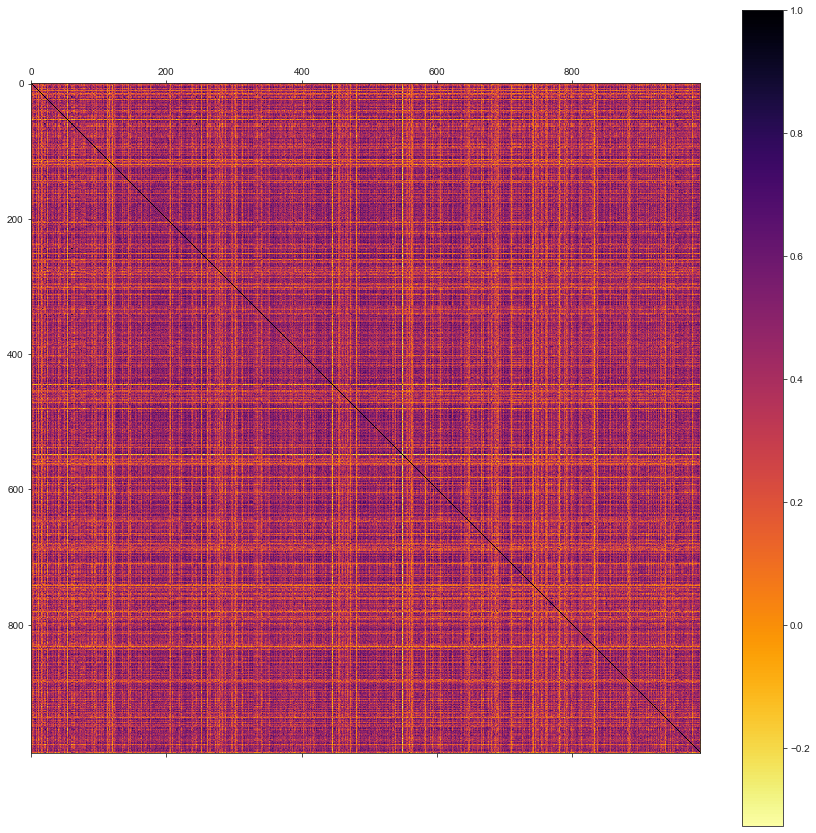

In [141]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(black_embed_0, black_embed_0), cmap='inferno_r')
img.figure.colorbar(img)

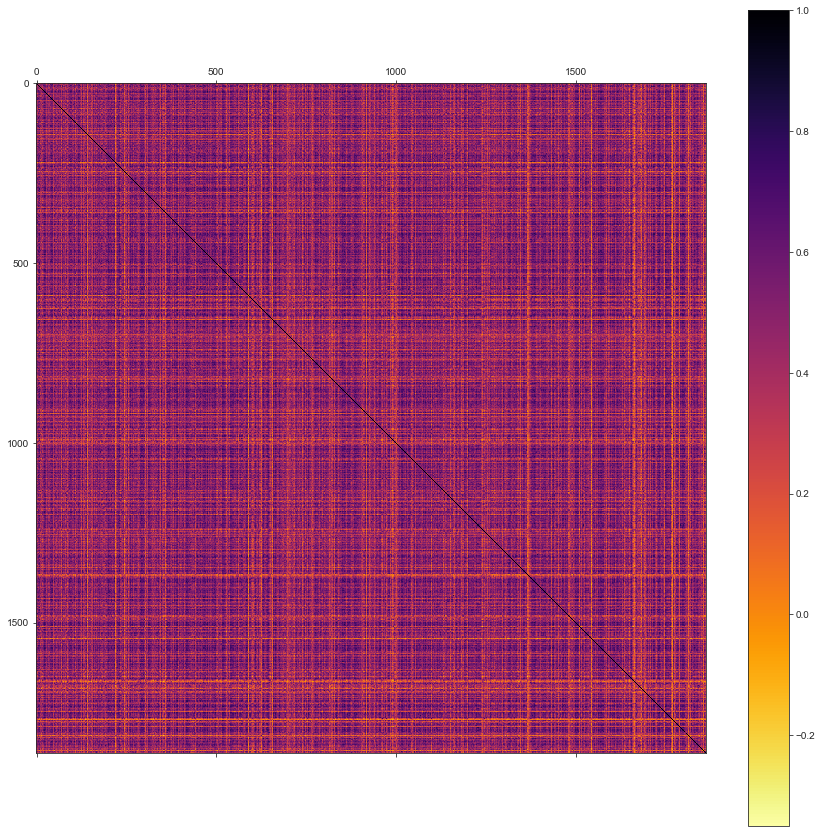

In [142]:
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(black_embed_2, black_embed_2), cmap='inferno_r')
img.figure.colorbar(img)

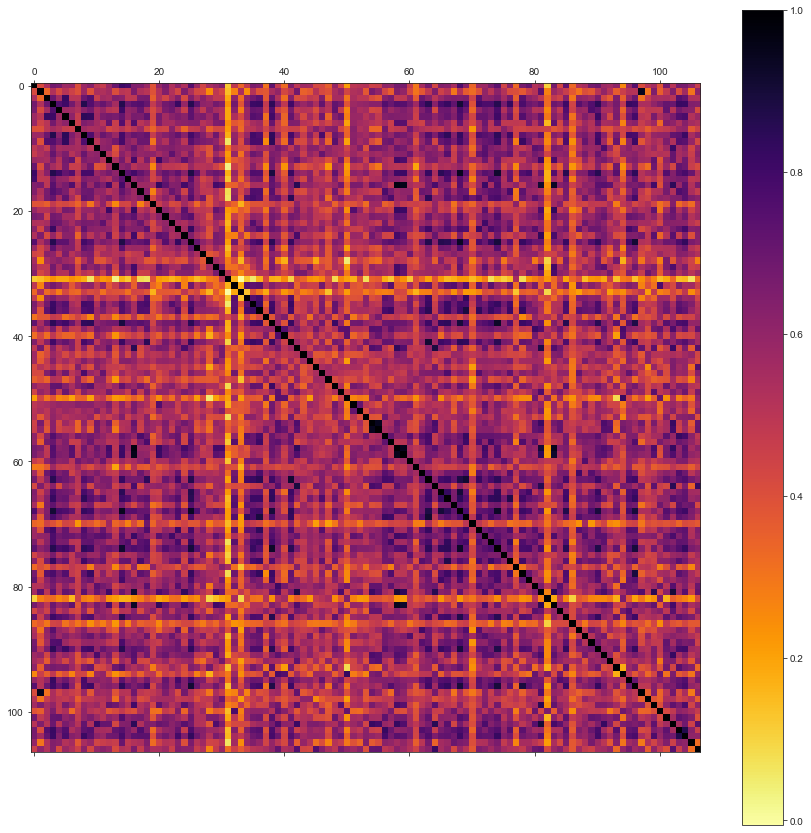

In [143]:
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(black_embed_5, black_embed_5), cmap='inferno_r')
img.figure.colorbar(img)

### Comparing White and Black responses

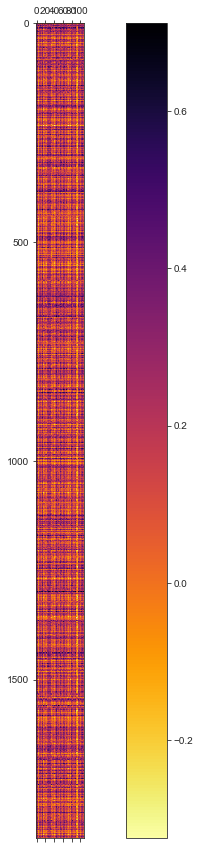

In [144]:
fig, ax = plt.subplots(figsize=(15, 15))
img= ax.matshow(confusion(black_embed_2, white_embed_2), cmap='inferno_r')
img.figure.colorbar(img)